In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.mode.chained_assignment = None

# Read in raw temperature data (df1) and grid (df2) from steps 1 and 2

- Need to run run.py to populate results directory with step[1,2]_output.csv

In [2]:
step1_path = "results/step1_output.csv"
step2_path = "results/step2_output.csv"

df1 = pd.read_csv(step1_path, index_col='Station_ID')
df2 = pd.read_csv(step2_path, index_col='Unnamed: 0')

# Gridding V0: Evaluate if series_next has 20 data points

In [3]:
def gridding_v0(df1, df2):

    missing_df_month = []
    missing_df_month_list = []

    # Loop through each point in 2x2 latxlon grid
    point_series_list = []
    for point in tqdm(range(len(df2))):

        # Create dataframe for all stations within range of given point
        nearby_station_str = str(df2.iloc[point]['Nearby_Stations'])
        nearby_station_dict = json.loads(nearby_station_str.replace("'", '"'))
        df_point = df1.loc[df1.index.isin(nearby_station_dict.keys())]
        
        # Loop through all months
        df_month_list = []
        for month in range(1, 13):
            
            # Filter months
            df_month = df_point.filter(regex=f'^{month}_')
            
            # Save original column names for later use
            original_columns = df_month.columns.tolist()
            
            # Add weights column
            df_month['Weight'] = df_month.index.map(lambda station_id: nearby_station_dict.get(station_id))
            
            # Sort stations by number of points
            df_month['Valid Data'] = df_month.filter(regex='_').count(axis=1)
            df_month = df_month.sort_values(by='Valid Data', ascending=False)
            
            # Calculate average per station if not already provided
            station_averages = df_month.filter(regex='_').mean(axis=1)

            # Only get monthly series if there are values
            if len(df_month) > 0:

                # Convert DataFrame to numpy for faster operations
                np_month = df_month.filter(regex='_').to_numpy()
                weights = df_month['Weight'].to_numpy()
                station_averages_np = station_averages.to_numpy()

                # Initialize combined series and weights
                series_combined = np_month[0, :]  # First station's data
                weight_combined = weights[0]

                # Initial mean, avoiding recalculation in each loop
                series_combined_mean = np.nanmean(series_combined) if np.sum(~np.isnan(series_combined)) > 0 else np.nan

                for i in range(1, len(np_month)):
                    series_next = np_month[i]
                    weight_next = weights[i]
                    station_next_avg = station_averages_np[i]

                    ###########################################################
                    ### Only use series_next if it has 20 valid data points ###
                    ###########################################################
                    station_next_valid_data_count = np.count_nonzero(~np.isnan(station_next_avg))
                    if station_next_valid_data_count >= 20:

                        # Calculate the new mean for combined series before updating
                        new_combined_mean = (series_combined_mean * weight_combined + station_next_avg * weight_next) / (weight_combined + weight_next)

                        # Adjust series_next using averages (vectorized)
                        series_next_adjusted = series_next + station_next_avg - series_combined_mean

                        # Update series_combined (vectorized)
                        valid_mask = ~np.isnan(series_next_adjusted)
                        series_combined[valid_mask] += series_next_adjusted[valid_mask] * weight_next

                        # Update combined weight
                        weight_combined += weight_next

                        # Update the combined mean
                        series_combined_mean = new_combined_mean

                # Convert the final combined series back to Pandas Series using the original column names
                final_series_combined = pd.Series(series_combined, index=original_columns)
                df_month_list.append(final_series_combined)

            else:
                point_month = str(point) + '_' + str(month)
                missing_df_month.append(point_month)

        if len(df_month_list) > 0:
            # Combine into series for all months, change index to point number
            complete_point_series = pd.concat(df_month_list, axis=0)
            complete_point_series.name = point

        else:
            missing_df_month_list.append(point)

        # Add complete point series to list
        point_series_list.append(complete_point_series)

    # Create dataframe of gridded time series for each point
    df_gridded = pd.concat(point_series_list, axis=1).T

    # Reorder columns to be in time-order
    ordered_columns = []
    for year in range(1880, 2024):
        for month in range(1, 13):
            ordered_columns.append(f'{month}_{year}')
    df_gridded = df_gridded[ordered_columns]

    # Add latitude / longitude coordinates
    df_gridded[['Latitude', 'Longitude']] = df2[['Latitude', 'Longitude']]

    # Clean out rows that should be all NaN
    df_clean = df_gridded.copy()
    anom_columns = df_clean.columns[:-2]
    for point in missing_df_month_list:
        df_clean.iloc[point][anom_columns] = np.nan
    for point_month in missing_df_month:
        point = int(point_month.split('_')[0])
        month = point_month.split('_')[1]
        month_cols = []
        for year in range(1880, 2024):
            month_cols.append((str(month) + '_' + str(year)))
        df_clean.iloc[point][month_cols] = np.nan

    return df_clean

In [4]:
df = gridding_v0(df1, df2)

100%|██████████| 16022/16022 [07:15<00:00, 36.80it/s]


# Anomaly Calculation: anomaly = raw - baseline_average

In [5]:
def calculate_anomalies(df_gridded):

    # Create dataframe for baseline columns
    df_baseline = df_gridded.copy()
    baseline_columns = []
    for year in range(1951, 1981):
        for month in range(1, 13):
            baseline_columns.append(str(month) + '_' + str(year))
    df_baseline = df_baseline[baseline_columns]

    # Calculate anomalies for each month
    df_monthly_anom_list = []
    for month in range(1, 13):

        # Get monthly dataframes and baseline averages
        monthly_columns = [col for col in df_gridded.columns if col.startswith(f'{month}_')]
        df_monthly_anom = df_gridded[monthly_columns]
        df_baseline[f'{month}_Average'] = df_baseline.mean(axis=1)
        df_monthly_anom[f'{month}_Average'] = df_baseline.mean(axis=1)

        # Calculate anomalies for each column
        for col in df_monthly_anom.columns:
            df_monthly_anom[col] = df_monthly_anom[col] - df_monthly_anom[f'{month}_Average']

        # Drop baseline average column, add to list
        df_monthly_anom = df_monthly_anom.drop(columns=[f'{month}_Average'])
        df_monthly_anom_list.append(df_monthly_anom)

    # Create dataframe and sort columns
    df_anom = pd.concat(df_monthly_anom_list, axis=1)
    temp_columns = []
    for year in range(1880, 2024):
        for month in range(1, 13):
            temp_columns.append(str(month) + '_' + str(year))
    df_anom = df_anom[temp_columns]

    # Add Latitude / Longitude coordinates
    lat_lon_columns = df_gridded[['Latitude', 'Longitude']].copy()
    df_anom = pd.concat([df_anom, lat_lon_columns], axis=1)

    return df_anom

# Convert dataframes to dataset

In [6]:
def dataframe_to_dataset(grid_anomaly: pd.DataFrame):
    """
    Convert a DataFrame with temperature data into an xarray Dataset.

    Parameters:
    - grid_anomaly (DataFrame): Input DataFrame with temperature data, containing columns 'Lat', 'Lon', and columns representing time steps.

    Returns:
    - Dataset: xarray Dataset with temperature data, indexed by latitude, longitude, and time.
    """

    # Create copy of input dataframe, rename columns
    df = grid_anomaly.copy()
    df = df.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    # Reshape dataframe into long format
    df = df.melt(id_vars=["lat", "lon"], var_name="date", value_name="temp")

    # Get months and years, drop duplicate rows
    df[["month", "year"]] = df["date"].str.split("_", expand=True).astype(int)
    df = df.drop_duplicates(subset=["lat", "lon", "month", "year"])

    # Create date column formatted as year-month-01
    dates = df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"

    # Convert dates to datetime objects
    datetimes = pd.to_datetime(dates)

    # Remove unnecessary columns
    df = df.drop(columns=["date", "month", "year"])

    # Create new time column using datetime objects
    df["time"] = pd.to_datetime(datetimes)

    # Set multi-index
    df = df.set_index(["lat", "lon", "time"])

    # Convert pandas dataframe to xarray dataset
    ds = df.to_xarray()
    return ds

# Equal Area Weighting

In [7]:
def area_weighted_timeseries(ds, yearly=False):
    weights = np.cos(np.deg2rad(ds['lat']))
    weights.name = 'weights'
    ds_weighted = ds.temp.weighted(weights)
    weighted_mean = ds_weighted.mean(('lon', 'lat'))
    yearly_weighted_timeseries = weighted_mean.resample(time='Y').mean(dim='time')
    return yearly_weighted_timeseries

In [8]:
def get_timeseries_dataset(df_gridded):
    df_anomaly = calculate_anomalies(df_gridded)
    ds = dataframe_to_dataset(df_anomaly)
    timeseries = area_weighted_timeseries(ds)
    return timeseries, ds

# Get baseline results

In [9]:
df_anomaly = calculate_anomalies(df)
timeseries, ds = get_timeseries_dataset(df)

# Plotting: Comparison of V4 & V5 

In [10]:
# Create v4 anomaly dataframe (steps 0-3)
df_v4 = pd.read_csv('data/df_v4.csv', index_col='Unnamed: 0')

# Create global average timeseries for v4
df_annual = df_v4.reindex(sorted(df_v4.columns), axis=1)
df_v4_timeseries = df_annual.mean(axis=0).values

In [11]:
def plot_v4_vs_v5(timeseries, title, color):

    fig, ax = plt.subplots()
    fig.patch.set_facecolor(color)

    plt.plot(timeseries, label='v5')
    plt.plot(df_v4_timeseries, label='v4')
    plt.axvline(x=70)
    plt.grid()
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Temperature Anomaly (Celsius)')
    plt.title(title)

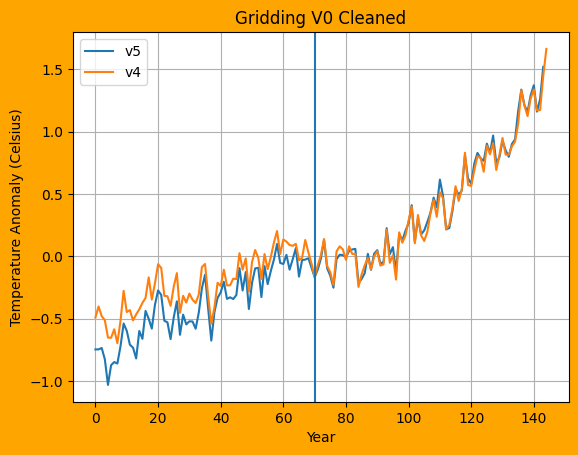

In [12]:
plot_v4_vs_v5(timeseries, 'Gridding V0 Cleaned', 'orange')

In [13]:
def spatial_plot(ds, index):
    most_recent_time = ds.time[index]
    temp_values = ds.temp.sel(time=most_recent_time)
    lon, lat = np.meshgrid(ds.lon, ds.lat)

    plt.figure(figsize=(10, 6))
    plt.contourf(lon, lat, temp_values, cmap='coolwarm')
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Most Recent Temperature Values ({most_recent_time})')
    plt.grid(True)
    plt.show()

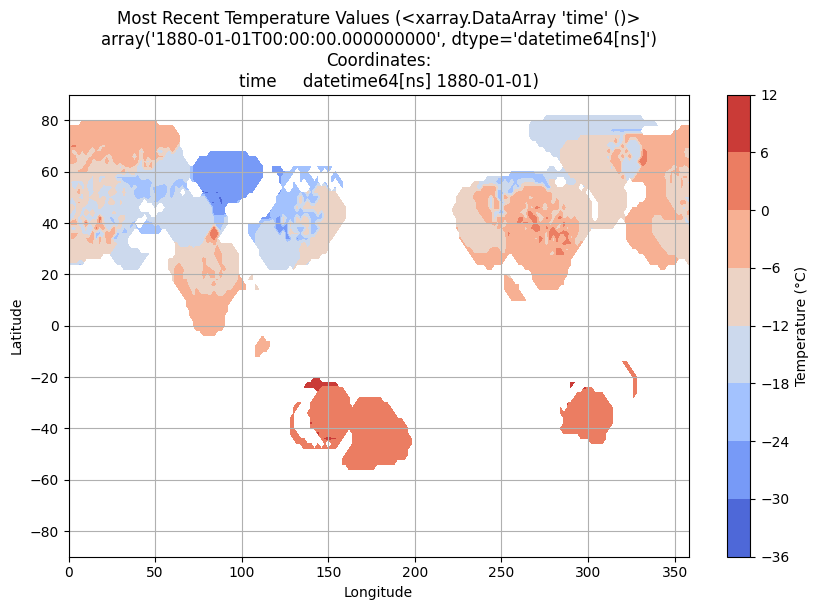

In [14]:
spatial_plot(ds, 0)